# Setup PySpark

In [ ]:
%%bash
# Do not change or modify this cell
# Need to install pyspark
# if pyspark is already installed, will print a message indicating pyspark already installed
pip install pyspark &> /dev/null

In [ ]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
import math
spark = SparkSession \
    .builder \
    .appName("group6") \
    .getOrCreate()
sc = SparkContext.getOrCreate()
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.ml import feature
from pyspark.ml import classification
from pyspark.sql import functions as fn
from pyspark.ml import Pipeline
import numpy as np
import seaborn as sns

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
#Grid seach condition
enable_grid_search = False

In [ ]:
#Importing class for ROC and PR curves

# see https://stackoverflow.com/questions/52847408/pyspark-extract-roc-curve
from pyspark.mllib.evaluation import BinaryClassificationMetrics

# Scala version implements .roc() and .pr()
# Python: https://spark.apache.org/docs/latest/api/python/_modules/pyspark/mllib/common.html
# Scala: https://spark.apache.org/docs/latest/api/java/org/apache/spark/mllib/evaluation/BinaryClassificationMetrics.html
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

#Data Import

In [ ]:
# Download the data files from github
# If the data file does not exist in the colab environment
%%bash
data_file_1=Employee_Attrition.csv

if [[ ! -f ./${data_file_1} ]]; then 
   # download the data file from github and save it in this colab environment instance
   wget https://raw.githubusercontent.com/rnvira/Employee-Attrition/main/${data_file_1} &> /dev/null
fi

In [ ]:
employee = spark.read.csv("Employee_Attrition.csv", header = True)
#employee = employee.drop("EmployeeCount","EmployeeNumber","Over18")
employee.printSchema()

root
 |-- satisfaction_level: string (nullable = true)
 |-- last_evaluation: string (nullable = true)
 |-- number_project: string (nullable = true)
 |-- average_montly_hours: string (nullable = true)
 |-- time_spend_company: string (nullable = true)
 |-- Work_accident: string (nullable = true)
 |-- left: string (nullable = true)
 |-- promotion_last_5years: string (nullable = true)
 |-- sales: string (nullable = true)
 |-- salary: string (nullable = true)



#Data Cleaning

In [ ]:
employee = employee.withColumn('satisfaction_level',employee['satisfaction_level'].cast('float'))\
          .withColumn('last_evaluation',employee['last_evaluation'].cast('float'))\
          .withColumn('average_monthly_hours', employee['average_montly_hours'].cast('float'))\
          .withColumn('time_spend_company', employee['time_spend_company'].cast('float'))\
          .withColumn('number_project',employee['number_project'].cast('int'))\
          .withColumnRenamed('sales', 'department')\
          .withColumn('attrition',employee['left'].cast('float'))
#Converting data types of attributes
#Added a column named "attrition" which is the same as "left". This is done to use in classification models

In [ ]:
employee.printSchema()

root
 |-- satisfaction_level: float (nullable = true)
 |-- last_evaluation: float (nullable = true)
 |-- number_project: integer (nullable = true)
 |-- average_montly_hours: string (nullable = true)
 |-- time_spend_company: float (nullable = true)
 |-- Work_accident: string (nullable = true)
 |-- left: string (nullable = true)
 |-- promotion_last_5years: string (nullable = true)
 |-- department: string (nullable = true)
 |-- salary: string (nullable = true)
 |-- average_monthly_hours: float (nullable = true)
 |-- attrition: float (nullable = true)



In [ ]:
# employee = employee.drop(employee.average_montly_hours)

In [ ]:
employee.show(5)

+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------+------+---------------------+---------+
|satisfaction_level|last_evaluation|number_project|average_montly_hours|time_spend_company|Work_accident|left|promotion_last_5years|department|salary|average_monthly_hours|attrition|
+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------+------+---------------------+---------+
|              0.38|           0.53|             2|                 157|               3.0|            0|   1|                    0|     sales|   low|                157.0|      1.0|
|               0.8|           0.86|             5|                 262|               6.0|            0|   1|                    0|     sales|medium|                262.0|      1.0|
|              0.11|           0.88|             7|                 272|             

In [ ]:
# import sql function pyspark
import pyspark.sql.functions as f

# checking for null values in each column
data_agg = employee.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in employee.columns])
data_agg.show()

#No missing values

+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------+------+---------------------+---------+
|satisfaction_level|last_evaluation|number_project|average_montly_hours|time_spend_company|Work_accident|left|promotion_last_5years|department|salary|average_monthly_hours|attrition|
+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------+------+---------------------+---------+
|                 0|              0|             0|                   0|                 0|            0|   0|                    0|         0|     0|                    0|        0|
+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------+------+---------------------+---------+



#Data Exploration

In [ ]:
import pandas as pd
import seaborn as sns

In [ ]:
#Descriptive statistics
employee.select('satisfaction_level','last_evaluation','number_project','time_spend_company','average_monthly_hours').describe().show()

+-------+-------------------+-------------------+------------------+------------------+---------------------+
|summary| satisfaction_level|    last_evaluation|    number_project|time_spend_company|average_monthly_hours|
+-------+-------------------+-------------------+------------------+------------------+---------------------+
|  count|              14999|              14999|             14999|             14999|                14999|
|   mean| 0.6128335220371535| 0.7161017401400102|  3.80305353690246| 3.498233215547703|    201.0503366891126|
| stddev|0.24863065162689157|0.17116911257197398|1.2325923553183513|1.4601362305354808|    49.94309937128406|
|    min|               0.09|               0.36|                 2|               2.0|                 96.0|
|    max|                1.0|                1.0|                 7|              10.0|                310.0|
+-------+-------------------+-------------------+------------------+------------------+---------------------+



In [ ]:
employee.groupBy("attrition").count().orderBy("attrition").show()
#we can see that the dataset is skewed towards attrition=0.0, hence we will performed stratified sampling

+---------+-----+
|attrition|count|
+---------+-----+
|      0.0|11428|
|      1.0| 3571|
+---------+-----+



[Text(0.5, 0, 'Attrition'),
 Text(0.5, 1.0, 'Bar plot of Attribution (1|0: Y|N)')]

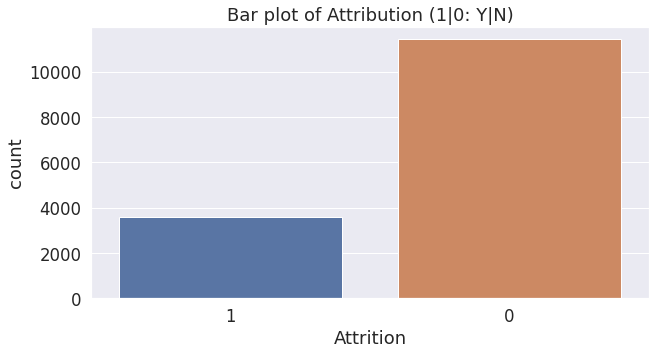

In [ ]:
sns.set(rc = {'figure.figsize':(10,5)})
sns.set(font_scale=1.5)
sns.countplot(data = employee.toPandas(), x = 'left').set(title = 'Bar plot of Attribution (1|0: Y|N)', xlabel='Attrition')
#We can see that the dataset is imbalanced

In [ ]:
employee=employee.sampleBy("attrition",fractions={0.0:0.3,1.0:1},seed=1234)
employee.groupBy("attrition").count().orderBy("attrition").show()
#Sampling the dataframe to get about 50% 0s and 50% 1s

+---------+-----+
|attrition|count|
+---------+-----+
|      0.0| 3453|
|      1.0| 3571|
+---------+-----+



In [ ]:
employee.toPandas().shape

(7024, 12)

[Text(0.5, 0, 'Attrition'),
 Text(0.5, 1.0, 'Bar plot of Attribution (1|0: Y|N)')]

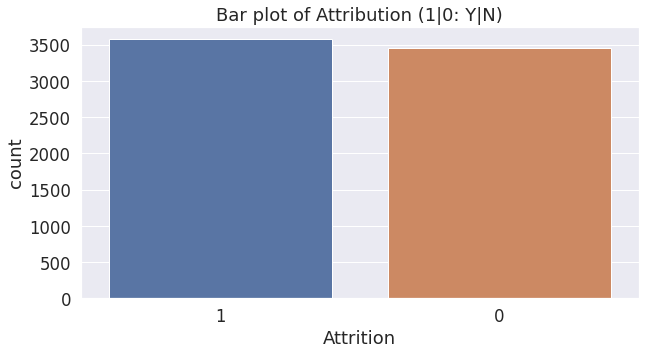

In [ ]:
#Can see almost 50% 1s and 0s
sns.set(rc = {'figure.figsize':(10,5)})
sns.set(font_scale=1.5)
sns.countplot(data = employee.toPandas(), x = 'left').set(title = 'Bar plot of Attribution (1|0: Y|N)', xlabel='Attrition')

In [ ]:
employee_pd = employee.toPandas()
#converting dataset to a pandas dataframe for visualization purposes

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.01, 'Pair plot of all numerical variables')

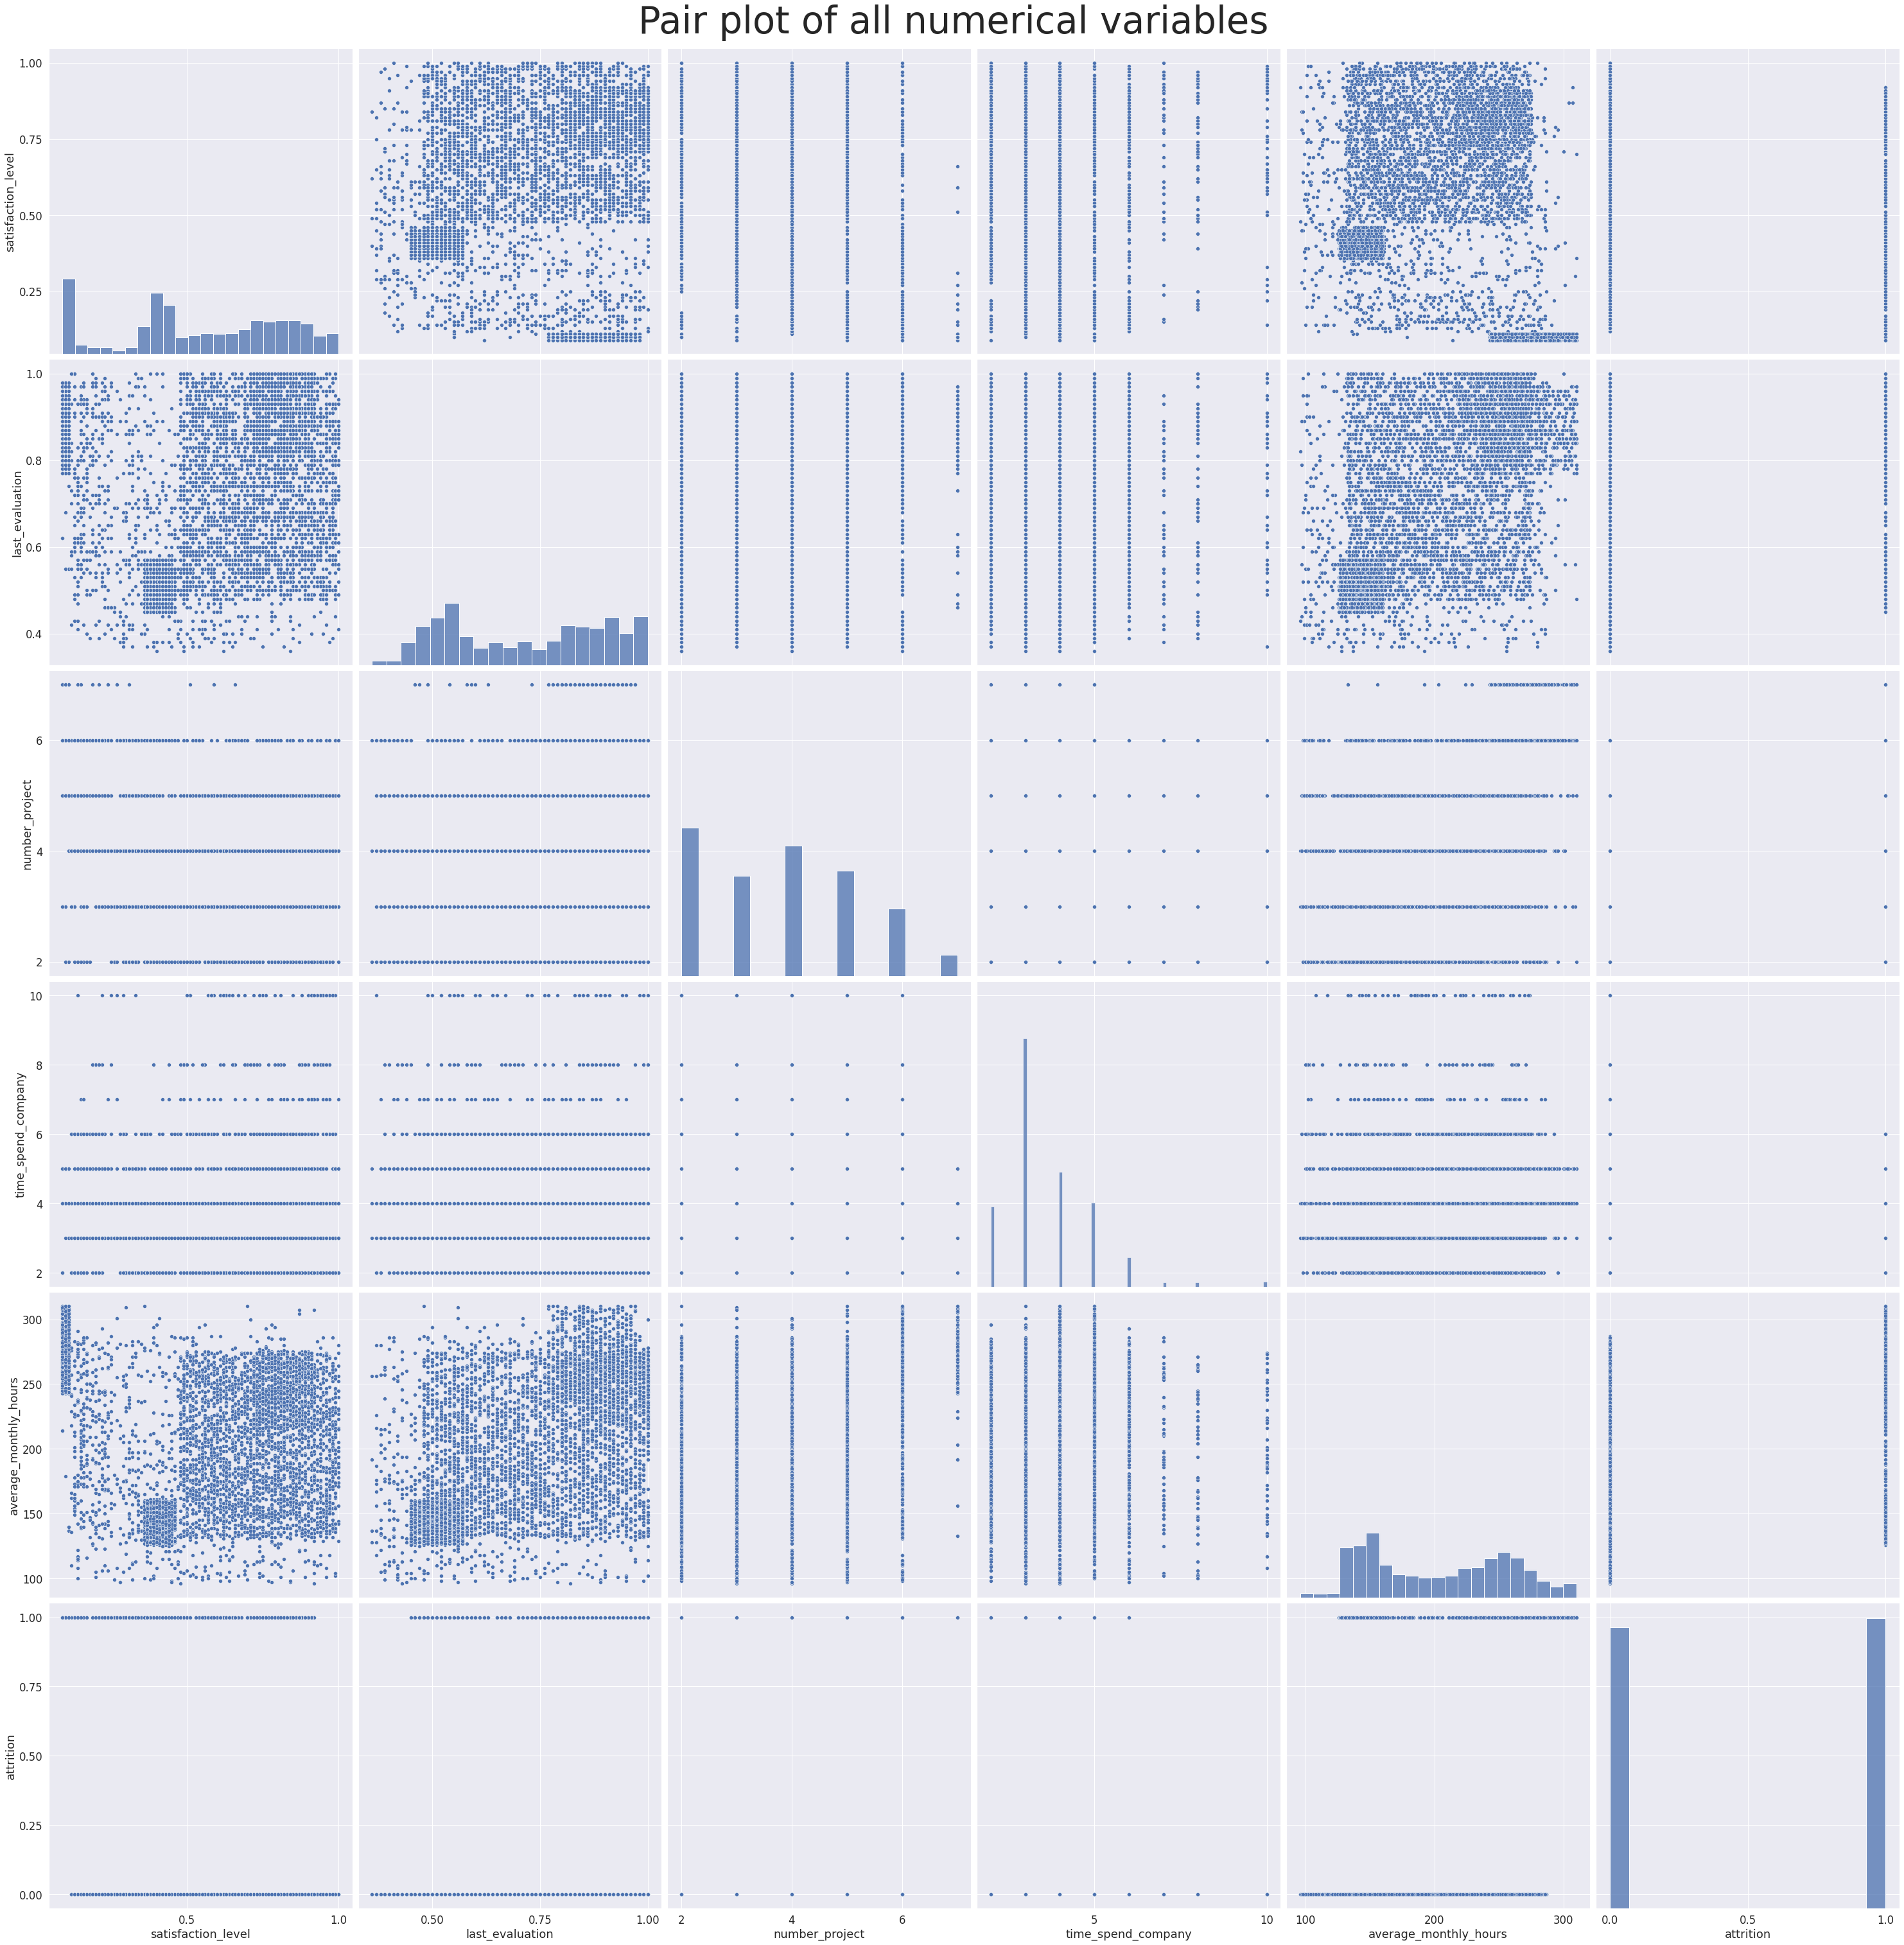

In [ ]:
#Pair plot
pp = sns.pairplot(employee_pd, size=7)
sns.set(font_scale=4)
pp.fig.suptitle("Pair plot of all numerical variables",y=1.01)

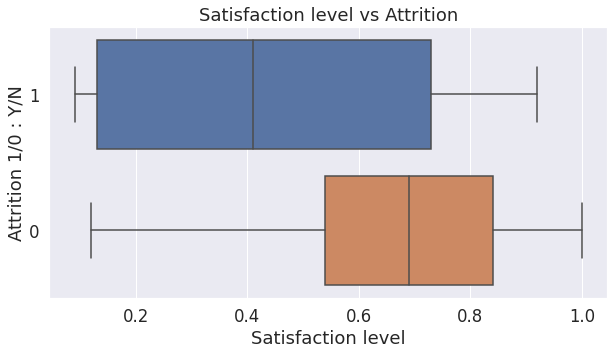

In [ ]:
# Satisfaction level vs Attrition boxplot
sns.set(rc = {'figure.figsize':(10,5)})
sns.set(font_scale=1.5)
age_attrition_hist = sns.boxplot(data=employee_pd, x = 'satisfaction_level', y = 'left').set(title = 'Satisfaction level vs Attrition',xlabel = 'Satisfaction level', ylabel = 'Attrition 1/0 : Y/N')

[Text(0, 0.5, 'Attrition 1/0 : Y/N'),
 Text(0.5, 0, 'Score'),
 Text(0.5, 1.0, 'Evaluation Score vs Attrition')]

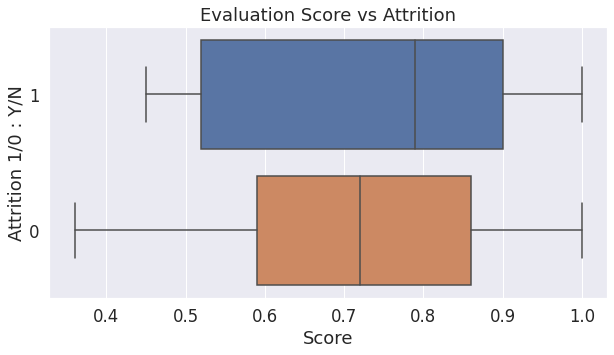

In [ ]:
# Evaluation score vs Attrition boxplot
sns.set(rc = {'figure.figsize':(10,5)})
sns.set(font_scale=1.5)
sns.boxplot(data = employee_pd, x = 'last_evaluation',y = 'left').set(title = 'Evaluation Score vs Attrition',xlabel = 'Score', ylabel = 'Attrition 1/0 : Y/N')

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Average Monthly Hours'),
 Text(0.5, 1.0, 'Distribution of average monthly hours')]

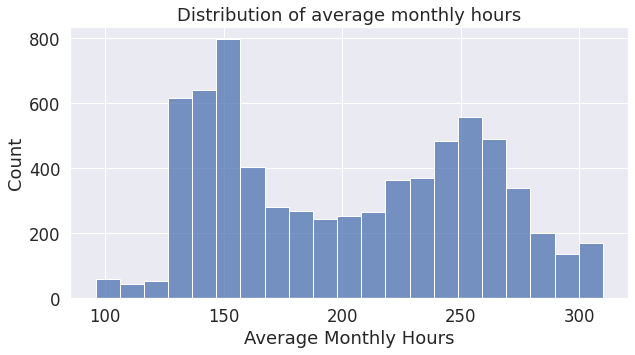

In [ ]:
# Distribution of average monthly hours
sns.set(rc = {'figure.figsize':(10,5)})
sns.set(font_scale=1.5)
sns.histplot(data=employee_pd,x='average_monthly_hours').set(title = 'Distribution of average monthly hours',xlabel = 'Average Monthly Hours', ylabel = 'Count')

[Text(0, 0.5, 'Last Evaluation'),
 Text(0.5, 0, 'Department'),
 Text(0.5, 1.0, 'Department wise Evaluation(last) with hue as Attrition')]

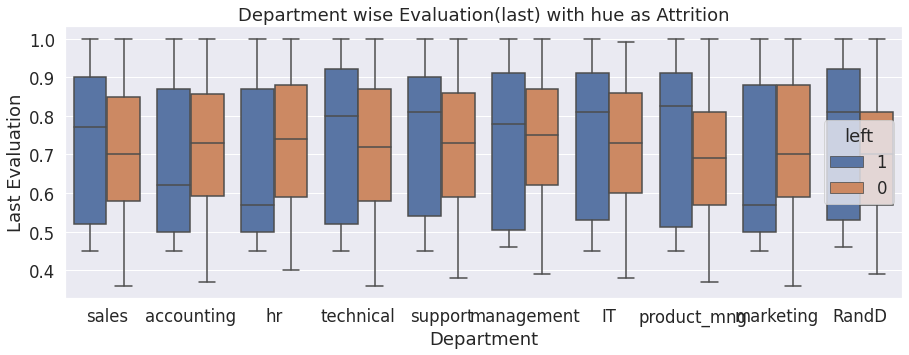

In [ ]:
# Department wise Evaluation(last) with hue as Attrition
sns.set(rc = {'figure.figsize':(15,5)})
sns.set(font_scale=1.5)
sns.boxplot(data = employee_pd, x = 'department', y = 'last_evaluation', hue = 'left').\
        set(title = 'Department wise Evaluation(last) with hue as Attrition',xlabel = 'Department', ylabel = 'Last Evaluation')

[Text(0, 0.5, 'Attrition 1/0 : Y/N'),
 Text(0.5, 0, 'Number of Projects'),
 Text(0.5, 1.0, 'Employee Project count')]

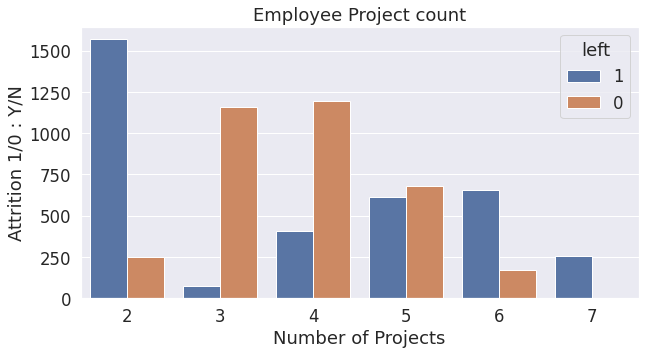

In [ ]:
# Employee project count
sns.set(rc = {'figure.figsize':(10,5)})
sns.set(font_scale=1.5)
sns.countplot(data = employee_pd, x = 'number_project', hue ='left').set(title = 'Employee Project count',xlabel = 'Number of Projects', ylabel = 'Attrition 1/0 : Y/N')

# Feature Engineering

In [ ]:
# Feature Engineering
from pyspark.ml.feature import OneHotEncoder, StringIndexer, Interaction, VectorAssembler
from pyspark.ml.functions import vector_to_array

#String indexing

department_indexer = StringIndexer(inputCol = 'department', outputCol = 'department_indexed', handleInvalid='skip')
salary_indexer = StringIndexer(inputCol = 'salary', outputCol = 'salary_indexed', handleInvalid='skip')
work_accident_indexer = StringIndexer(inputCol = 'Work_accident', outputCol = 'Work_accident_indexed', handleInvalid='skip')
promotion_last_5years_indexer = StringIndexer(inputCol = 'promotion_last_5years', outputCol = 'promotion_last_5years_indexed', handleInvalid='skip')

#one hot encoding

department_OneHot = OneHotEncoder(inputCol = 'department_indexed', outputCol = 'en_department')
salary_OneHot = OneHotEncoder(inputCol = 'salary_indexed', outputCol = 'en_salary')
work_accident_OneHot = OneHotEncoder(inputCol = 'Work_accident_indexed', outputCol = 'en_Work_accident')
promotion_last_5years_OneHot = OneHotEncoder(inputCol = 'promotion_last_5years_indexed', outputCol = 'en_promotion_last_5years')

#Vector Assembler

vector_assembler = VectorAssembler(inputCols=['en_department','en_salary','en_Work_accident','en_promotion_last_5years',\
                                              'last_evaluation','number_project','time_spend_company',\
                                              'average_monthly_hours'], outputCol='features')

In [ ]:
train, validation, test = employee.randomSplit([0.6, 0.3, 0.1],2010)

In [ ]:
from pyspark.ml import Pipeline

fe_pipe = Pipeline(stages=[department_indexer, salary_indexer, work_accident_indexer, promotion_last_5years_indexer,\
                           department_OneHot, salary_OneHot, work_accident_OneHot, promotion_last_5years_OneHot,\
                           vector_assembler])

# Regression - satisfaction level

We use regression models such as Linear, Random forest and Gradient Boosting trees to predict the satisfaction level of an employee.

## Linear Regression

In [ ]:
from pyspark.ml import regression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
lr = regression.LinearRegression(featuresCol='features', labelCol='satisfaction_level') 

In [ ]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=False, withMean=True)

In [ ]:
#encapusulating linear regression pipeline and fe_pipe
lr_pipe = Pipeline(stages=[fe_pipe, scaler, lr])

In [ ]:
lr_model = lr_pipe.fit(train)

In [ ]:
#prediction
lr_employee_df = lr_model.transform(test)

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

lr_mse_evaluator = RegressionEvaluator(labelCol="satisfaction_level", predictionCol="prediction", metricName="mse")
lr_mse_train = lr_mse_evaluator.evaluate(lr_model.transform(train))
lr_mse_test = lr_mse_evaluator.evaluate(lr_employee_df)

lr_rmse_evaluator = RegressionEvaluator(labelCol="satisfaction_level", predictionCol="prediction", metricName="rmse")
lr_rmse_train = lr_rmse_evaluator.evaluate(lr_model.transform(train))
lr_rmse_test = lr_rmse_evaluator.evaluate(lr_employee_df)

In [ ]:
print("MSE of the model is:", lr_mse_test)
print("RMSE of the model is:", lr_rmse_test)

MSE of the model is: 0.06058559732705419
RMSE of the model is: 0.24614141733372338


### Inferences

In [ ]:
lr_list_extract = []
for i in lr_employee_df.schema['features'].metadata["ml_attr"]["attrs"]:
  lr_list_extract = lr_list_extract + lr_employee_df.schema['features'].metadata["ml_attr"]["attrs"][i]

In [ ]:
lr_varlist = pd.DataFrame(lr_list_extract)
lr_varlist['score'] = lr_model.stages[-1].coefficients

In [ ]:
#Sorting by absolute value to find the most important feature
lr_varlist.reindex(lr_varlist.score.abs().sort_values(ascending=False).index).head(7)

,idx,name,score
13,9,en_salary_low,0.507289
12,8,en_department_RandD,-0.078224
9,5,en_department_accounting,-0.068710
14,10,en_salary_medium,-0.060745
10,6,en_department_marketing,-0.058500
11,7,en_department_hr,-0.052305
8,4,en_department_product_mng,0.050922


## Random Forest Regression

In [ ]:
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor

In [ ]:
# Random Forest Regressor
rfr = RandomForestRegressor(featuresCol='features', labelCol='satisfaction_level')

rfr_pipe = Pipeline(stages=[department_indexer, salary_indexer, work_accident_indexer, promotion_last_5years_indexer,\
                            VectorAssembler(inputCols=['last_evaluation','number_project','time_spend_company','average_monthly_hours',\
                           'department_indexed','salary_indexed','Work_accident_indexed','promotion_last_5years_indexed'], outputCol='features'),\
                            rfr])

In [ ]:
rfr_model = rfr_pipe.fit(train)

In [ ]:
# Creating Evaluators
from pyspark.ml.evaluation import RegressionEvaluator

rfr_evaluator_mse = RegressionEvaluator(predictionCol="prediction", labelCol="satisfaction_level", metricName="mse")
rfr_evaluator_rmse = RegressionEvaluator(predictionCol="prediction", labelCol="satisfaction_level", metricName="rmse")

In [ ]:
#grid for random forest
if(enable_grid_search):
  grid = ParamGridBuilder().\
          addGrid(rfr_model.stages[-1].maxDepth, [2, 3, 4]).\
          addGrid(rfr_model.stages[-1].maxBins, [10, 15, 20]).\
          addGrid(rfr_model.stages[-1].numTrees, [10, 15, 20]).\
          build()
  all_models = []
  for j in range(len(grid)):
      model = rfr_pipe.fit(train, grid[j])
      all_models.append(model)
  mse = [m.\
      transform(validation)
      for m in all_models]
  model_mse = []
  for i in range(len(mse)):
      model_mse.append(rfr_evaluator_mse.evaluate(mse[i]))
  best = min(model_mse)
  best_model_idx = model_mse.index(best)
  print(grid[best_model_idx])
  print(best)
  pass

In [ ]:
# Tuning the Hypeparameters
best_rfr = RandomForestRegressor(featuresCol='features', labelCol='satisfaction_level', maxDepth=4, maxBins=15, numTrees=15)
inf_rfr_pipe = Pipeline(stages=[department_indexer, salary_indexer, work_accident_indexer, promotion_last_5years_indexer,\
                            VectorAssembler(inputCols=['last_evaluation','number_project','time_spend_company','average_monthly_hours',
                                                       'department_indexed','salary_indexed','Work_accident_indexed','promotion_last_5years_indexed'], outputCol='features'), best_rfr])

In [ ]:
inf_rfr_model = inf_rfr_pipe.fit(train)

### Inferences

In [ ]:
feature_importance_rfr = dict(zip(inf_rfr_model.stages[-2].getInputCols(), inf_rfr_model.stages[-1].featureImportances))

In [ ]:
feature_rfr = feature_importance_rfr.keys()
importance_rfr = feature_importance_rfr.values()

In [ ]:
import pandas as pd

rf_feature_importance = pd.DataFrame({'feature': feature_rfr, 'importance': importance_rfr})
rf_feature_importance.sort_values(by='importance', ascending=False, inplace=True)

In [ ]:
display(rf_feature_importance)

,feature,importance
1,number_project,0.619146
3,average_monthly_hours,0.190401
0,last_evaluation,0.141553
2,time_spend_company,0.037275
4,department_indexed,0.007488
5,salary_indexed,0.002846
6,Work_accident_indexed,0.001291
7,promotion_last_5years_indexed,0.000000


[Text(0.5, 1.0, 'RF Regressor Feature Importance')]

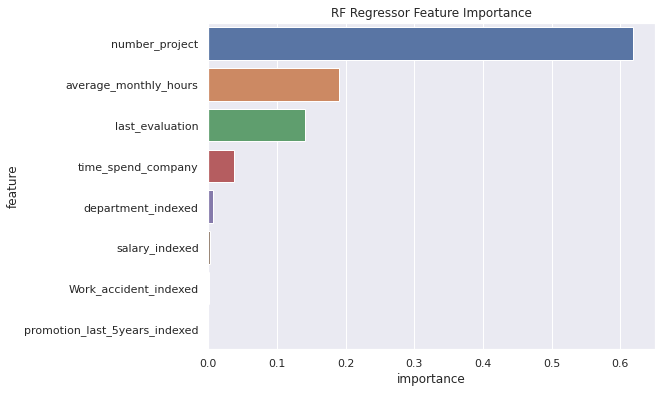

In [ ]:
sns.set(rc={'figure.figsize':(8,6)})
sns.barplot(data = rf_feature_importance, y= 'feature', x='importance').set(title = 'RF Regressor Feature Importance')

###Model Tuning

In [ ]:
#Using the inference model, we removed the features with less importance
best_rf_pipe = Pipeline(stages=[department_indexer, salary_indexer, work_accident_indexer, promotion_last_5years_indexer,\
                            VectorAssembler(inputCols=['last_evaluation','number_project','time_spend_company','average_monthly_hours'], outputCol='features'), best_rfr])

best_rfr_model = best_rf_pipe.fit(train)
best_rfr_pred = best_rfr_model.transform(test)

In [ ]:
rfr_mse_test = rfr_evaluator_mse.evaluate(best_rfr_pred)
rfr_mse_train = rfr_evaluator_mse.evaluate(best_rfr_model.transform(train))

rfr_rmse_test = rfr_evaluator_rmse.evaluate(best_rfr_pred)
rfr_rmse_train = rfr_evaluator_rmse.evaluate(best_rfr_model.transform(train))

In [ ]:
print("MSE of the model is:", rfr_mse_test)
print("RMSE of the model is:", rfr_rmse_test)

MSE of the model is: 0.02378845521577557
RMSE of the model is: 0.15423506480620927


## GBT Regressor

In [ ]:
# Creating GBT regressor
gbt = GBTRegressor(featuresCol= 'features', labelCol= 'satisfaction_level')
gbt_pipe = Pipeline(stages=[department_indexer, salary_indexer, work_accident_indexer, promotion_last_5years_indexer,\
                            VectorAssembler(inputCols=['last_evaluation','number_project','time_spend_company','average_monthly_hours',\
                                            'department_indexed','salary_indexed','Work_accident_indexed','promotion_last_5years_indexed'], outputCol= 'features'),
                            gbt])                         

In [ ]:
gbt_model = gbt_pipe.fit(train)

In [ ]:
# grid for gbt
if(enable_grid_search):
  grid = ParamGridBuilder().\
          addGrid(gbt_model.stages[-1].maxDepth, [7,8,9]).\
          addGrid(gbt_model.stages[-1].maxBins, [70, 100, 150]).\
          addGrid(gbt_model.stages[-1].minInstancesPerNode, [10, 20, 30]).\
          build()
  all_models = []
  for j in range(len(grid)):
      model_gbt = gbt_pipe.fit(train, grid[j])
      all_models.append(model_gbt)
  mse = [m.\
      transform(validation)
      for m in all_models]
  model_mse = []
  for i in range(len(mse)):
      model_mse.append(rfr_evaluator_mse.evaluate(mse[i]))
  best = min(model_mse)
  best_model_gbt_idx = model_mse.index(best)
  print(grid[best_model_gbt_idx])
  print(best)
  pass

In [ ]:
# Tuning the hyper parameters
inf_gbt_pipe = Pipeline(stages=[department_indexer, salary_indexer, work_accident_indexer, promotion_last_5years_indexer,\
                            VectorAssembler(inputCols=['last_evaluation','number_project','time_spend_company','average_monthly_hours',\
                                            'department_indexed','salary_indexed','Work_accident_indexed','promotion_last_5years_indexed'], outputCol= 'features'),
                            GBTRegressor(featuresCol= 'features', labelCol= 'satisfaction_level',minInstancesPerNode = 10,maxBins = 100,maxDepth = 7)])

In [ ]:
inf_gbt_model = inf_gbt_pipe.fit(train)

### Inferences

In [ ]:
inf_gbt_model.stages[-1].featureImportances

SparseVector(8, {0: 0.188, 1: 0.3547, 2: 0.0916, 3: 0.2034, 4: 0.1246, 5: 0.0229, 6: 0.0118, 7: 0.003})

In [ ]:
feature_importance_gbt = dict(zip(inf_gbt_model.stages[-2].getInputCols(), inf_gbt_model.stages[-1].featureImportances))

In [ ]:
feature_gbt = feature_importance_gbt.keys()
importance_gbt = feature_importance_gbt.values()

In [ ]:
import pandas as pd

gbt_feature_importance = pd.DataFrame({'feature': feature_gbt, 'importance': importance_gbt})
gbt_feature_importance.sort_values(by='importance', ascending=False, inplace=True)

In [ ]:
display(gbt_feature_importance)

,feature,importance
1,number_project,0.354675
3,average_monthly_hours,0.203399
0,last_evaluation,0.188044
4,department_indexed,0.124558
2,time_spend_company,0.091646
5,salary_indexed,0.022922
6,Work_accident_indexed,0.011756
7,promotion_last_5years_indexed,0.003001


[Text(0.5, 1.0, 'GBT Regressor Feature Importance')]

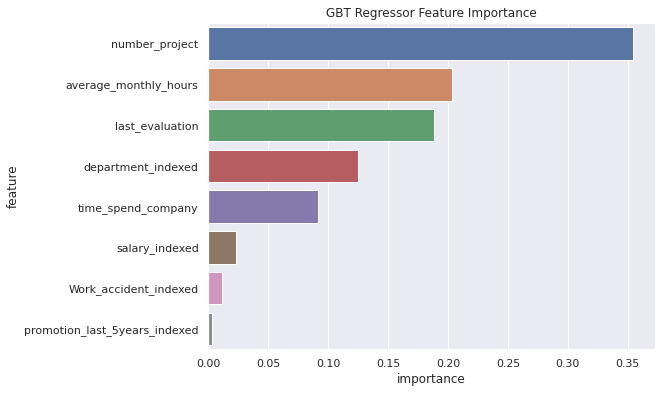

In [ ]:
sns.set(rc={'figure.figsize':(8,6)})
sns.barplot(data = gbt_feature_importance, y= 'feature', x='importance').set(title = 'GBT Regressor Feature Importance')

### Model Tuning

In [ ]:
# Best Model. We removed the features with less imporatnce
best_gbt_pipe = Pipeline(stages=[department_indexer, salary_indexer, work_accident_indexer, promotion_last_5years_indexer,\
                            VectorAssembler(inputCols=['last_evaluation','number_project','time_spend_company','average_monthly_hours'], outputCol= 'features'),
                            GBTRegressor(featuresCol= 'features', labelCol= 'satisfaction_level',minInstancesPerNode = 10,maxBins = 100,maxDepth = 7)])

In [ ]:
best_gbt_model = best_gbt_pipe.fit(train)

In [ ]:
best_gbt_pred = best_gbt_model.transform(validation)

In [ ]:
gbt_mse_test = rfr_evaluator_mse.evaluate(best_gbt_pred)
gbt_mse_train = rfr_evaluator_rmse.evaluate(best_gbt_model.transform(train))

gbt_rmse_test = rfr_evaluator_rmse.evaluate(best_gbt_pred)
gbt_rmse_train = rfr_evaluator_rmse.evaluate(best_gbt_model.transform(train))

In [ ]:
print("MSE of the model is:", gbt_mse_test)
print("RMSE of the model is:", gbt_rmse_test)

MSE of the model is: 0.027178607481490293
RMSE of the model is: 0.16485935666952692


# Model Comparisions - Regression Models

In [ ]:
# Comparing the regressors. Metics used: MSE, RMSE
regressor_model = ['Linear Regression', 'Random Forest Regressor', 'Gradient Boosting Tree Regressor']

regressor_mse_test = [lr_mse_test, rfr_mse_test, gbt_mse_test]
regressor_rmse_test = [lr_rmse_test, rfr_rmse_test, gbt_rmse_test]

regressor_mse_train = [lr_mse_train, rfr_mse_train, gbt_mse_train]
regressor_rmse_train = [lr_rmse_train, rfr_rmse_train, gbt_rmse_train]

In [ ]:
regressor_mse_rmse_pd = pd.DataFrame({'Model': regressor_model, 'Test MSE': regressor_mse_test, \
                                      'Test RMSE': regressor_rmse_test})

In [ ]:
regressor_mse_rmse_pd

,Model,Test MSE,Test RMSE
0,Linear Regression,0.060586,0.246141
1,Random Forest Regressor,0.023788,0.154235
2,Gradient Boosting Tree Regressor,0.027179,0.164859


# Classification - attrition

We use classification models such as Logistic, Random forest, Gradient Boosting trees, Multilayer Perceptron and SVM to predict whether an employee leaves the company or not (attrition).

## Logistic Regression

In [ ]:
# Creating Logistic regressor
from pyspark.ml import classification
from pyspark.ml.evaluation import BinaryClassificationEvaluator, \
    MulticlassClassificationEvaluator, \
    RegressionEvaluator
lg_pipe = Pipeline(stages=[department_indexer, salary_indexer, work_accident_indexer, promotion_last_5years_indexer,\
                           department_OneHot, salary_OneHot, work_accident_OneHot, promotion_last_5years_OneHot,\
                          VectorAssembler(inputCols=['en_department','en_salary','en_Work_accident',\
                                                                        'en_promotion_last_5years',\
                                              'last_evaluation','number_project','time_spend_company',\
                                              'average_monthly_hours','satisfaction_level'], outputCol='features'),
                           classification.LogisticRegression(featuresCol = 'features', labelCol = 'attrition')])

In [ ]:
lg_model = lg_pipe.fit(train)

In [ ]:
lg_pred = lg_model.transform(test)

In [ ]:
#Accuracy
lg_acc_test = BinaryClassificationEvaluator().setLabelCol("attrition").evaluate(lg_pred)
lg_acc_train = BinaryClassificationEvaluator().setLabelCol("attrition").evaluate(lg_model.transform(train))

In [ ]:
# Area under ROC Curve
lg_auc = BinaryClassificationMetrics(lg_pred['attrition','prediction'].rdd).areaUnderROC

In [ ]:
#Scoring metrics for testing
from pyspark.mllib.evaluation import MulticlassMetrics
lg_predictionAndLabels_test = lg_pred.select(['prediction', 'attrition']).rdd
lg_metrics_test = MulticlassMetrics(lg_predictionAndLabels_test)

In [ ]:
lg_cm_test=lg_metrics_test.confusionMatrix().toArray()
lg_precision_test=(lg_cm_test[0][0])/(lg_cm_test[0][0]+lg_cm_test[1][0])
lg_recall_test=(lg_cm_test[0][0])/(lg_cm_test[0][0]+lg_cm_test[0][1])

In [ ]:
lg_f1_test=2*(lg_precision_test*lg_recall_test)/(lg_precision_test+lg_recall_test)
# lg_acc_test_f1score

In [ ]:
#Scoring metrics for training
from pyspark.mllib.evaluation import MulticlassMetrics
lg_predictionAndLabels_train = lg_model.transform(train).select(['prediction', 'attrition']).rdd
lg_metrics_train = MulticlassMetrics(lg_predictionAndLabels_train)

In [ ]:
# Calculating precision recall
lg_cm_train=lg_metrics_train.confusionMatrix().toArray()
lg_precision_train=(lg_cm_train[0][0])/(lg_cm_train[0][0]+lg_cm_train[1][0])
lg_recall_train=(lg_cm_train[0][0])/(lg_cm_train[0][0]+lg_cm_train[0][1])

In [ ]:
lg_f1_train=2*(lg_precision_train*lg_recall_train)/(lg_precision_train+lg_recall_train)
# lg_acc_train_f1score

In [ ]:
print('Accuracy:', lg_acc_test) #Accuracy
print('AUC:', lg_auc) #AUC
print('Recall:', lg_recall_test) #Recall
print('Precision:', lg_precision_test) #Precision
print('F1-Score:', lg_f1_test) #F1 score

Accuracy: 0.8323086487980079
AUC: 0.783903648172459
Recall: 0.7750759878419453
Precision: 0.7774390243902439
F1-Score: 0.7762557077625571


### Inferences

In [ ]:
lg_list_extract = []
for i in lg_pred.schema['features'].metadata["ml_attr"]["attrs"]:
  lg_list_extract = lg_list_extract + lg_pred.schema['features'].metadata["ml_attr"]["attrs"][i]

In [ ]:
lg_varlist = pd.DataFrame(lg_list_extract)
lg_varlist['score'] = lg_model.stages[-1].coefficients

In [ ]:
#Sorting by absolute value to find the most important feature
lg_varlist.reindex(lg_varlist.score.abs().sort_values(ascending=False).index)

,idx,name,score
17,12,en_promotion_last_5years_0,-4.368143
9,4,en_department_product_mng,2.158816
12,7,en_department_hr,1.984340
10,5,en_department_accounting,1.582516
11,6,en_department_marketing,1.365504
13,8,en_department_RandD,1.031911
1,14,number_project,0.922077
2,15,time_spend_company,0.787091
7,2,en_department_support,0.759707
5,0,en_department_sales,0.674862


### ROC and PR curve

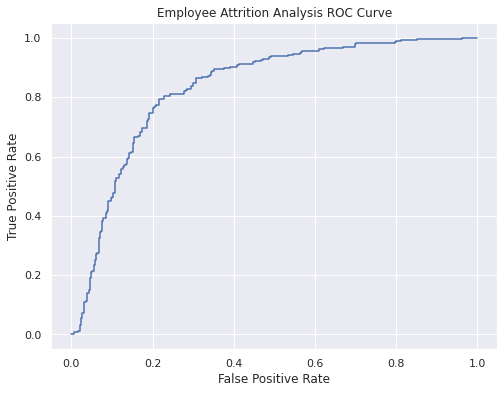

In [ ]:
import matplotlib.pyplot as plt
# Returns as a list (false positive rate, true positive rate)
preds = lg_pred.select('attrition','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['attrition'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('Employee Attrition Analysis ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(x_val, y_val)

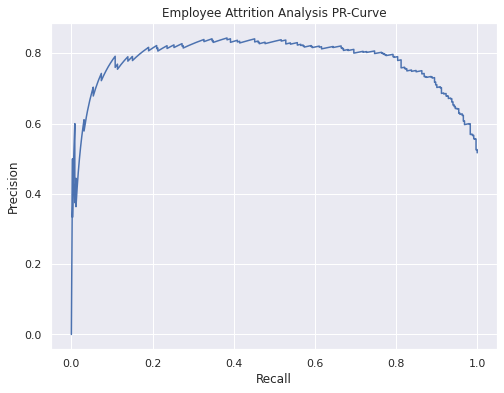

In [ ]:
import matplotlib.pyplot as plt
# Returns as a list (false positive rate, true positive rate)
preds = lg_pred.select('attrition','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['attrition'])))
points = CurveMetrics(preds).get_curve('pr')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('Employee Attrition Analysis PR-Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(x_val, y_val)

## Random Forest Classifier

In [ ]:
rfr_cl_pipe = Pipeline(stages=[department_indexer, salary_indexer, work_accident_indexer, promotion_last_5years_indexer,\
                            VectorAssembler(inputCols=['satisfaction_level','last_evaluation','number_project','time_spend_company','average_monthly_hours',\
                           'department_indexed','salary_indexed','Work_accident_indexed','promotion_last_5years_indexed'], outputCol = 'features'),
                           classification.RandomForestClassifier(featuresCol='features', labelCol= 'attrition')])

In [ ]:
rfr_cl_model = rfr_cl_pipe.fit(train)

In [ ]:
# grid search for random forest Classifier
if(enable_grid_search):
  grid = ParamGridBuilder().\
          addGrid(rfr_cl_model.stages[-1].maxDepth, [2, 3, 4]).\
          addGrid(rfr_cl_model.stages[-1].numTrees, [5, 15, 10]).\
          build()
  all_models = []
  for j in range(len(grid)):
      model = rfr_cl_pipe.fit(train, grid[j])
      all_models.append(model)
  accuracies = [m.\
    transform(validation).\
    select(fn.avg(fn.expr('float(attrition = prediction)')).alias('accuracy')).\
    first().\
    accuracy for m in all_models]
  best_model_idx = np.argmax(accuracies)
  print(grid[best_model_idx])
  pass 

In [ ]:
# Tuning the hyperparameters
inf_rfr_pipe = Pipeline(stages=[department_indexer, salary_indexer, work_accident_indexer, promotion_last_5years_indexer,\
                            VectorAssembler(inputCols=['satisfaction_level','last_evaluation','number_project','time_spend_company','average_monthly_hours',\
                           'department_indexed','salary_indexed','Work_accident_indexed','promotion_last_5years_indexed'], outputCol = 'features'),
                           classification.RandomForestClassifier(featuresCol='features', labelCol= 'attrition', maxDepth = 4, numTrees = 10)])
inf_rfr_model = inf_rfr_pipe.fit(train)

In [ ]:
inf_pred = inf_rfr_model.transform(test)

### Inferences

In [ ]:
feature_importance_inf_rf_cl = dict(zip(inf_rfr_model.stages[-2].getInputCols(), inf_rfr_model.stages[-1].featureImportances))

In [ ]:
feature_rf_cl = feature_importance_inf_rf_cl.keys()
importance_rf_cl = feature_importance_inf_rf_cl.values()
inf_rf_cl_feature_importance = pd.DataFrame({'feature': feature_rf_cl, 'importance': importance_rf_cl})
inf_rf_cl_feature_importance.sort_values(by='importance', ascending=False, inplace=True)

In [ ]:
display(inf_rf_cl_feature_importance)

,feature,importance
3,time_spend_company,0.300387
2,number_project,0.220360
0,satisfaction_level,0.206063
4,average_monthly_hours,0.147646
1,last_evaluation,0.109944
6,salary_indexed,0.007769
7,Work_accident_indexed,0.007485
5,department_indexed,0.000345
8,promotion_last_5years_indexed,0.000000


[Text(0.5, 1.0, 'RF Classifier Feature Importance')]

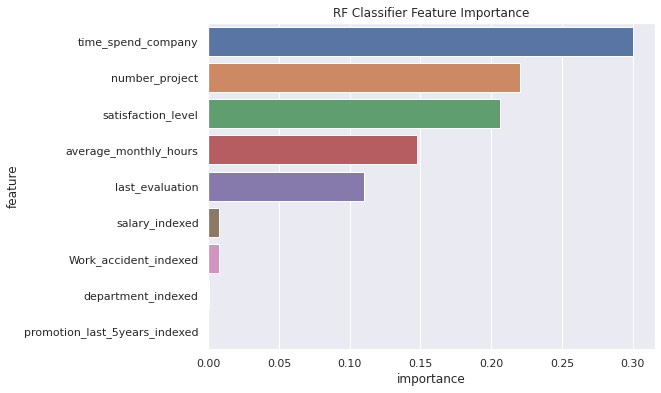

In [ ]:
sns.set(rc={'figure.figsize':(8,6)})
sns.barplot(data = inf_rf_cl_feature_importance, y= 'feature', x='importance').set(title = 'RF Classifier Feature Importance')

###Model Tuning

In [ ]:
# Removing the features with low importance
best_rfr_cl_pipe = Pipeline(stages=[department_indexer, salary_indexer, work_accident_indexer, promotion_last_5years_indexer,\
                            VectorAssembler(inputCols=['satisfaction_level','last_evaluation','number_project','time_spend_company','average_monthly_hours'], outputCol = 'features'),
                           classification.RandomForestClassifier(featuresCol='features', labelCol= 'attrition', maxDepth = 4, numTrees = 10, seed=1)])

In [ ]:
best_rfr_cl_model = best_rfr_cl_pipe.fit(train)

In [ ]:
best_rfr_cl_pred = best_rfr_cl_model.transform(test)

In [ ]:
#Accuracy
rfr_acc_test = BinaryClassificationEvaluator().setLabelCol("attrition").evaluate(best_rfr_cl_pred)
rfr_acc_train = BinaryClassificationEvaluator().setLabelCol("attrition").evaluate(best_rfr_cl_model.transform(train))

In [ ]:
# Area under ROC Curve
rfr_auc = BinaryClassificationMetrics(best_rfr_cl_pred['attrition','prediction'].rdd).areaUnderROC

In [ ]:
#Scoring metrics for testing
from pyspark.mllib.evaluation import MulticlassMetrics
rfr_predictionAndLabels_test = best_rfr_cl_pred.select(['prediction', 'attrition']).rdd
rfr_metrics_test = MulticlassMetrics(rfr_predictionAndLabels_test)

In [ ]:
rfr_cm_test=rfr_metrics_test.confusionMatrix().toArray()
rfr_precision_test=(rfr_cm_test[0][0])/(rfr_cm_test[0][0]+rfr_cm_test[1][0])
rfr_recall_test=(rfr_cm_test[0][0])/(rfr_cm_test[0][0]+rfr_cm_test[0][1])

In [ ]:
rfr_f1_test=2*(rfr_precision_test*rfr_recall_test)/(rfr_precision_test+rfr_recall_test)
# lg_acc_test_f1score

In [ ]:
#Scoring metrics for training
from pyspark.mllib.evaluation import MulticlassMetrics
rfr_predictionAndLabels_train = best_rfr_cl_model.transform(train).select(['prediction', 'attrition']).rdd
rfr_metrics_train = MulticlassMetrics(rfr_predictionAndLabels_train)

In [ ]:
rfr_cm_train=rfr_metrics_train.confusionMatrix().toArray()
rfr_precision_train=(rfr_cm_train[0][0])/(rfr_cm_train[0][0]+rfr_cm_train[1][0])
rfr_recall_train=(rfr_cm_train[0][0])/(rfr_cm_train[0][0]+rfr_cm_train[0][1])

In [ ]:
rfr_f1_train=2*(rfr_precision_train*rfr_recall_train)/(rfr_precision_train+rfr_recall_train)
# lg_acc_train_f1score

In [ ]:
print('Accuracy:', rfr_acc_test) #Accuracy
print('AUC:', rfr_auc) #AUC
print('Recall:', rfr_recall_test) #Recall
print('Precision:', rfr_precision_test) #Precision
print('F1-Score:', rfr_f1_test) #F1 score

Accuracy: 0.9762581168831169
AUC: 0.9467480657640232
Recall: 0.9787234042553191
Precision: 0.9147727272727273
F1-Score: 0.9456681350954478


### ROC and PR Curve

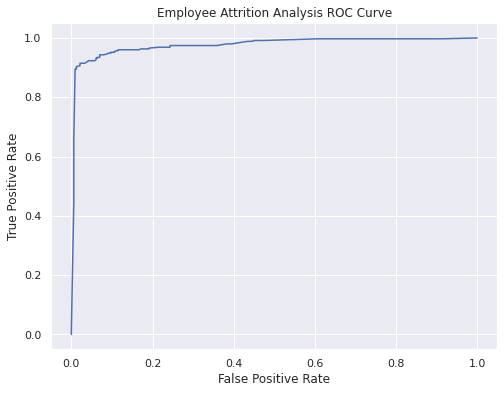

In [ ]:
import matplotlib.pyplot as plt
# Returns as a list (false positive rate, true positive rate)
preds = best_rfr_cl_pred.select('attrition','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['attrition'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('Employee Attrition Analysis ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(x_val, y_val)

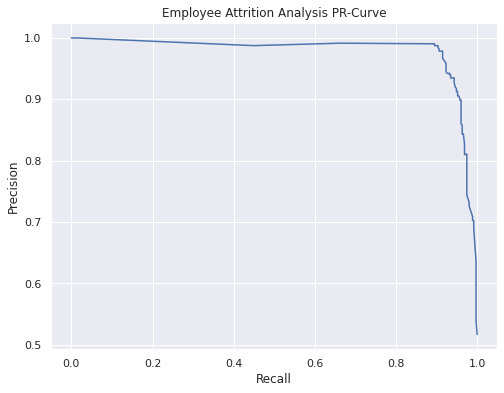

In [ ]:
import matplotlib.pyplot as plt
# Returns as a list (false positive rate, true positive rate)
preds = best_rfr_cl_pred.select('attrition','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['attrition'])))
points = CurveMetrics(preds).get_curve('pr')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('Employee Attrition Analysis PR-Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(x_val, y_val)

## GBT Classifier - Attrition

In [ ]:
# Creating GBT classifier
gbt_cl_pipe = Pipeline(stages=[department_indexer, salary_indexer, work_accident_indexer, promotion_last_5years_indexer,\
                            VectorAssembler(inputCols=['satisfaction_level','last_evaluation','number_project','time_spend_company','average_monthly_hours',\
                           'department_indexed','salary_indexed','Work_accident_indexed','promotion_last_5years_indexed'], outputCol = 'features'),
                           classification.GBTClassifier(featuresCol='features', labelCol= 'attrition')])

In [ ]:
gbt_cl_model = gbt_cl_pipe.fit(train)

In [ ]:
#grid search for gbt
if(enable_grid_search):
  grid = ParamGridBuilder().\
          addGrid(gbt_cl_model.stages[-1].maxDepth, [7,8,9]).\
          addGrid(gbt_cl_model.stages[-1].maxBins, [70, 100, 150]).\
          addGrid(gbt_cl_model.stages[-1].minInstancesPerNode, [10, 20, 30]).\
          build()
  all_models = []
  for j in range(len(grid)):
      model_gbt_cl = gbt_cl_pipe.fit(train, grid[j])
      all_models.append(model_gbt_cl)
  accuracies = [m.\
    transform(validation).\
    select(fn.avg(fn.expr('float(attrition = prediction)')).alias('accuracy')).\
    first().\
    accuracy for m in all_models]
  best_model_idx = np.argmax(accuracies)
  print(grid[best_model_idx])
  pass

In [ ]:
# Tuning the model
inf_gbt_pipe = Pipeline(stages=[department_indexer, salary_indexer, work_accident_indexer, promotion_last_5years_indexer,\
                            VectorAssembler(inputCols=['satisfaction_level','last_evaluation','number_project','time_spend_company','average_monthly_hours',\
                           'department_indexed','salary_indexed','Work_accident_indexed','promotion_last_5years_indexed'], outputCol = 'features'),
                           classification.GBTClassifier(featuresCol='features', labelCol= 'attrition',maxDepth = 8, maxBins = 100, minInstancesPerNode= 10)])

In [ ]:
inf_gbt_model = inf_gbt_pipe.fit(train)

###Inferences

In [ ]:
feature_importance_inf_gbt_cl = dict(zip(inf_gbt_model.stages[-2].getInputCols(), inf_gbt_model.stages[-1].featureImportances))

In [ ]:
feature_inf_gbt_cl = feature_importance_inf_gbt_cl.keys()
importance_inf_gbt_cl = feature_importance_inf_gbt_cl.values()
inf_gbt_feature_importance_cl = pd.DataFrame({'feature': feature_inf_gbt_cl, 'importance': importance_inf_gbt_cl})
inf_gbt_feature_importance_cl.sort_values(by='importance', ascending=False, inplace=True)

In [ ]:
display(inf_gbt_feature_importance_cl)

,feature,importance
0,satisfaction_level,0.397553
3,time_spend_company,0.269411
1,last_evaluation,0.110133
4,average_monthly_hours,0.106771
5,department_indexed,0.052043
2,number_project,0.047483
6,salary_indexed,0.014291
7,Work_accident_indexed,0.002315
8,promotion_last_5years_indexed,0.000000


[Text(0.5, 1.0, 'GBT Classifier Feature Importance')]

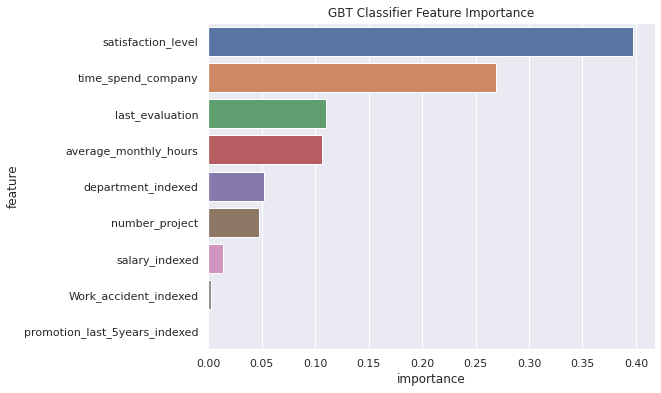

In [ ]:
sns.set(rc={'figure.figsize':(8,6)})
sns.barplot(data = inf_gbt_feature_importance_cl, y= 'feature', x='importance').set(title = 'GBT Classifier Feature Importance')

### Model Tuning

In [ ]:
# We removed the features with low importance
best_gbt_cl_pipe = Pipeline(stages=[department_indexer, salary_indexer, work_accident_indexer, promotion_last_5years_indexer,\
                            VectorAssembler(inputCols=['satisfaction_level','last_evaluation','time_spend_company','average_monthly_hours'],\
                                            outputCol = 'features'),
                            classification.GBTClassifier(featuresCol='features', labelCol= 'attrition', maxDepth = 8, maxBins = 100, minInstancesPerNode= 10, seed=1)])

In [ ]:
best_gbt_cl_model = best_gbt_cl_pipe.fit(train)

In [ ]:
best_gbt_cl_pred = best_gbt_cl_model.transform(validation)

In [ ]:
#Accuracy
gbt_acc_test = BinaryClassificationEvaluator().setLabelCol("attrition").evaluate(best_gbt_cl_pred)
gbt_acc_train = BinaryClassificationEvaluator().setLabelCol("attrition").evaluate(best_gbt_cl_model.transform(train))

In [ ]:
# Area under ROC Curve
gbt_auc = BinaryClassificationMetrics(best_gbt_cl_pred['attrition','prediction'].rdd).areaUnderROC

In [ ]:
#Scoring metrics for testing
from pyspark.mllib.evaluation import MulticlassMetrics
gbt_predictionAndLabels_test = best_gbt_cl_pred.select(['prediction', 'attrition']).rdd
gbt_metrics_test = MulticlassMetrics(gbt_predictionAndLabels_test)

In [ ]:
gbt_cm_test=gbt_metrics_test.confusionMatrix().toArray()
gbt_precision_test=(gbt_cm_test[0][0])/(gbt_cm_test[0][0]+gbt_cm_test[1][0])
gbt_recall_test=(gbt_cm_test[0][0])/(gbt_cm_test[0][0]+gbt_cm_test[0][1])

In [ ]:
gbt_f1_test=2*(gbt_precision_test*gbt_recall_test)/(gbt_precision_test+gbt_recall_test)
# lg_acc_test_f1score

In [ ]:
#Scoring metrics for training
from pyspark.mllib.evaluation import MulticlassMetrics
gbt_predictionAndLabels_train = best_gbt_cl_model.transform(train).select(['prediction', 'attrition']).rdd
gbt_metrics_train = MulticlassMetrics(gbt_predictionAndLabels_train)

In [ ]:
gbt_cm_train=gbt_metrics_train.confusionMatrix().toArray()
gbt_precision_train=(gbt_cm_train[0][0])/(gbt_cm_train[0][0]+gbt_cm_train[1][0])
gbt_recall_train=(gbt_cm_train[0][0])/(gbt_cm_train[0][0]+gbt_cm_train[0][1])

In [ ]:
gbt_f1_train=2*(gbt_precision_train*gbt_recall_train)/(gbt_precision_train+gbt_recall_train)
# lg_acc_train_f1score

In [ ]:
print('Accuracy:', gbt_acc_test) #Accuracy
print('AUC:', gbt_auc) #AUC
print('Recall:', gbt_recall_test) #Recall
print('Precision:', gbt_precision_test) #Precision
print('F1-Score:', gbt_f1_test) #F1 score

Accuracy: 0.9834636383451097
AUC: 0.9522851682527502
Recall: 0.969416126042632
Precision: 0.9372759856630825
F1-Score: 0.9530751708428246


### ROC and PR curve

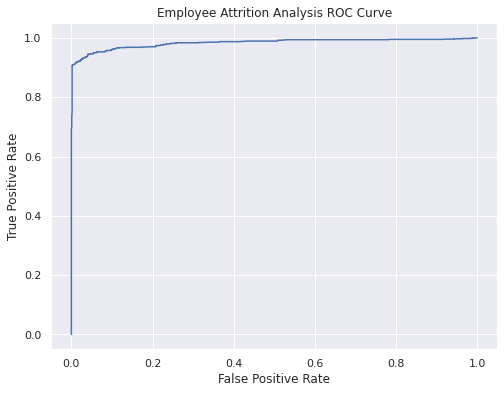

In [ ]:
import matplotlib.pyplot as plt
# Returns as a list (false positive rate, true positive rate)
preds = best_gbt_cl_pred.select('attrition','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['attrition'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('Employee Attrition Analysis ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(x_val, y_val)

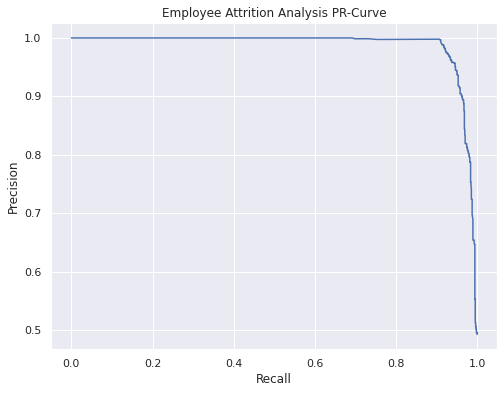

In [ ]:
import matplotlib.pyplot as plt
# Returns as a list (false positive rate, true positive rate)
preds = best_gbt_cl_pred.select('attrition','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['attrition'])))
points = CurveMetrics(preds).get_curve('pr')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('Employee Attrition Analysis PR-Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(x_val, y_val)

##MultilayerPerceptron Classifier

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

In [ ]:
# creating MultilayerPerceptronClassifier
mlp_pipe = Pipeline(stages = [department_indexer, salary_indexer, work_accident_indexer, promotion_last_5years_indexer,\
                            VectorAssembler(inputCols=['satisfaction_level','last_evaluation','number_project','time_spend_company','average_monthly_hours',\
                           'department_indexed','salary_indexed','Work_accident_indexed','promotion_last_5years_indexed'], outputCol = 'features'),
                           MultilayerPerceptronClassifier(featuresCol= 'features', labelCol='attrition', layers = [9,17,23])])

In [ ]:
mlp_model = mlp_pipe.fit(train)

In [ ]:
# gird for mlp
if enable_grid_search:
  grid = ParamGridBuilder().\
         addGrid(mlp_model.stages[-1].maxIter, [200, 250, 300]).\
         addGrid(mlp_model.stages[-1].stepSize, [0.6, 0.7, 0.8]).\
         build()
  all_models = []
  for j in range(len(grid)):
      model_mlp = mlp_pipe.fit(train, grid[j])
      all_models.append(model_mlp)
  accuracies = [m.\
    transform(train).\
    select(fn.avg(fn.expr('float(attrition = prediction)')).alias('accuracy')).\
    first().\
    accuracy for m in all_models]
  best_model_idx = np.argmax(accuracies)
  print(grid[best_model_idx])
  pass

In [ ]:
# Tuning the hyper parameters
inf_mlp_pipe = Pipeline(stages = [department_indexer, salary_indexer, work_accident_indexer, promotion_last_5years_indexer,\
                            VectorAssembler(inputCols=['satisfaction_level','last_evaluation','number_project','time_spend_company','average_monthly_hours',\
                           'department_indexed','salary_indexed','Work_accident_indexed','promotion_last_5years_indexed'], outputCol = 'features'),
                           MultilayerPerceptronClassifier(featuresCol= 'features', labelCol='attrition', layers = [9,1,1,2], maxIter = 100, stepSize = 0.1)])
inf_mlp_model = inf_mlp_pipe.fit(train)

###Inferences

Since, feature importances cannot be extracted in MLP model, we used the other classifiers with less importance to remove features.

###Model Tuning

In [ ]:
# we reomved the features with low imporatance based on output from gbt
# This was done beacause mlp model does not give feature importances
best_mlp_pipe = Pipeline(stages=[department_indexer, salary_indexer, work_accident_indexer, promotion_last_5years_indexer,\
                            VectorAssembler(inputCols=['satisfaction_level','last_evaluation','number_project','time_spend_company','average_monthly_hours'], outputCol = 'features'),
                            MultilayerPerceptronClassifier(featuresCol= 'features', labelCol='attrition', layers = [5,7,2],maxIter = 200, stepSize = 0.6, seed=1)])

In [ ]:
best_mlp_model = best_mlp_pipe.fit(train)
best_mlp_pred = best_mlp_model.transform(test)

In [ ]:
#Accuracy
mlp_acc_test = BinaryClassificationEvaluator().setLabelCol("attrition").evaluate(best_mlp_pred)
mlp_acc_train = BinaryClassificationEvaluator().setLabelCol("attrition").evaluate(best_mlp_model.transform(train))

In [ ]:
# Area under ROC Curve
mlp_auc = BinaryClassificationMetrics(best_mlp_pred['attrition','prediction'].rdd).areaUnderROC

In [ ]:
#Scoring metrics for testing
from pyspark.mllib.evaluation import MulticlassMetrics
mlp_predictionAndLabels_test = best_mlp_pred.select(['prediction', 'attrition']).rdd
mlp_metrics_test = MulticlassMetrics(mlp_predictionAndLabels_test)

In [ ]:
mlp_cm_test=mlp_metrics_test.confusionMatrix().toArray()
mlp_precision_test=(mlp_cm_test[0][0])/(mlp_cm_test[0][0]+mlp_cm_test[1][0])
mlp_recall_test=(mlp_cm_test[0][0])/(mlp_cm_test[0][0]+mlp_cm_test[0][1])

In [ ]:
mlp_f1_test=2*(mlp_precision_test*mlp_recall_test)/(mlp_precision_test+mlp_recall_test)
# lg_acc_test_f1score

In [ ]:
#Scoring metrics for training
from pyspark.mllib.evaluation import MulticlassMetrics
mlp_predictionAndLabels_train = best_mlp_model.transform(train).select(['prediction', 'attrition']).rdd
mlp_metrics_train = MulticlassMetrics(mlp_predictionAndLabels_train)

In [ ]:
mlp_cm_train=mlp_metrics_train.confusionMatrix().toArray()
mlp_precision_train=(mlp_cm_train[0][0])/(mlp_cm_train[0][0]+mlp_cm_train[1][0])
mlp_recall_train=(mlp_cm_train[0][0])/(mlp_cm_train[0][0]+mlp_cm_train[0][1])

In [ ]:
mlp_f1_train=2*(mlp_precision_train*mlp_recall_train)/(mlp_precision_train+mlp_recall_train)
# lg_acc_train_f1score

In [ ]:
print('Accuracy:', mlp_acc_test) #Accuracy
print('AUC:', mlp_auc) #AUC
print('Recall:', mlp_recall_test) #Recall
print('Precision:', mlp_precision_test) #Precision
print('F1-Score:', mlp_f1_test) #F1 score

Accuracy: 0.8592195703232937
AUC: 0.8741067410674106
Recall: 0.7689969604863222
Precision: 0.933579335793358
F1-Score: 0.8433333333333334


### ROC and PR Curve

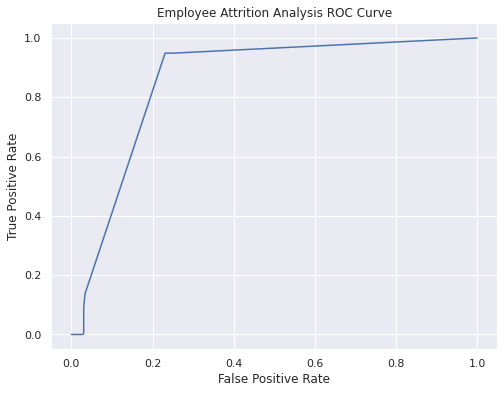

In [ ]:
import matplotlib.pyplot as plt
# Returns as a list (false positive rate, true positive rate)
preds = best_mlp_pred.select('attrition','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['attrition'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('Employee Attrition Analysis ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(x_val, y_val)

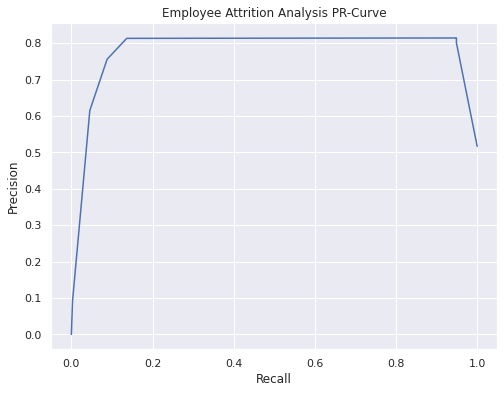

In [ ]:
import matplotlib.pyplot as plt
# Returns as a list (false positive rate, true positive rate)
preds = best_mlp_pred.select('attrition','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['attrition'])))
points = CurveMetrics(preds).get_curve('pr')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('Employee Attrition Analysis PR-Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(x_val, y_val)

##LinearSVM

In [ ]:
from pyspark.ml.classification import LinearSVC

In [ ]:
# creating a support vector machine
svc_pipe = Pipeline(stages = [department_indexer, salary_indexer, work_accident_indexer, promotion_last_5years_indexer,\
                              VectorAssembler(inputCols=['satisfaction_level','last_evaluation','number_project','time_spend_company','average_monthly_hours',\
                             'department_indexed','salary_indexed','Work_accident_indexed','promotion_last_5years_indexed'], outputCol = 'features'),
                              LinearSVC(featuresCol= 'features', labelCol = 'attrition')])

In [ ]:
svc_model = svc_pipe.fit(train)

In [ ]:
svc_pred = svc_model.transform(test)

In [ ]:
# grid for svm
if(enable_grid_search):
  grid = ParamGridBuilder().\
          addGrid(svc_model.stages[-1].regParam, [0.1, 0.01]).\
          addGrid(svc_model.stages[-1].maxIter, [1,50,10]).\
          addGrid(svc_model.stages[-1].threshold, [0.1 , 1. , 10.]).\
          build()
  all_models = []
  for j in range(len(grid)):
      model = svc_pipe.fit(train, grid[j])
      all_models.append(model)
  accuracies = [m.\
    transform(validation).\
    select(fn.avg(fn.expr('float(attrition = prediction)')).alias('accuracy')).\
    first().\
    accuracy for m in all_models]
  best_model_idx = np.argmax(accuracies)
  print(grid[best_model_idx])
  pass


In [ ]:
inf_svc_pipe = Pipeline(stages = [department_indexer, salary_indexer, work_accident_indexer, promotion_last_5years_indexer,\
                                  VectorAssembler(inputCols=['satisfaction_level','last_evaluation','number_project','time_spend_company','average_monthly_hours',\
                                 'department_indexed','salary_indexed','Work_accident_indexed','promotion_last_5years_indexed'], outputCol = 'features'),
                              LinearSVC(featuresCol= 'features', labelCol = 'attrition',regParam=0.01,maxIter=10,threshold=0.1)])

In [ ]:
inf_svc_model = inf_svc_pipe.fit(train)
inf_svc_pred = inf_svc_model.transform(test)

###Inference

Since, feature importances cannot be extracted in MLP model, we used the other classifiers with less importance to remove features.

### Model Tuning

In [ ]:
best_svc_pipe = Pipeline(stages = [department_indexer, salary_indexer, work_accident_indexer, promotion_last_5years_indexer,\
                            VectorAssembler(inputCols=['satisfaction_level','last_evaluation','number_project','time_spend_company','average_monthly_hours'], outputCol = 'features'),
                              LinearSVC(featuresCol= 'features', labelCol = 'attrition',regParam=0.01,maxIter=10,threshold=0.1 )])

In [ ]:
best_svc_model = best_svc_pipe.fit(train)
best_svc_pred = best_svc_model.transform(test)

In [ ]:
#Accuracy
svc_acc_test = BinaryClassificationEvaluator().setLabelCol("attrition").evaluate(best_svc_pred)
svc_acc_train = BinaryClassificationEvaluator().setLabelCol("attrition").evaluate(best_svc_model.transform(train))

In [ ]:
# Area under ROC Curve
svc_auc = BinaryClassificationMetrics(best_svc_pred['attrition','prediction'].rdd).areaUnderROC

In [ ]:
#Scoring metrics for testing
from pyspark.mllib.evaluation import MulticlassMetrics
svc_predictionAndLabels_test = best_svc_pred.select(['prediction', 'attrition']).rdd
svc_metrics_test = MulticlassMetrics(svc_predictionAndLabels_test)

In [ ]:
svc_cm_test=svc_metrics_test.confusionMatrix().toArray()
svc_precision_test=(svc_cm_test[0][0])/(svc_cm_test[0][0]+svc_cm_test[1][0])
svc_recall_test=(svc_cm_test[0][0])/(svc_cm_test[0][0]+svc_cm_test[0][1])

In [ ]:
svc_f1_test=2*(svc_precision_test*svc_recall_test)/(svc_precision_test+svc_recall_test)
# lg_acc_test_f1score

In [ ]:
#Scoring metrics for training
from pyspark.mllib.evaluation import MulticlassMetrics
svc_predictionAndLabels_train = best_svc_model.transform(train).select(['prediction', 'attrition']).rdd
svc_metrics_train = MulticlassMetrics(svc_predictionAndLabels_train)

In [ ]:
svc_cm_train=svc_metrics_train.confusionMatrix().toArray()
svc_precision_train=(svc_cm_train[0][0])/(svc_cm_train[0][0]+svc_cm_train[1][0])
svc_recall_train=(svc_cm_train[0][0])/(svc_cm_train[0][0]+svc_cm_train[0][1])

In [ ]:
svc_f1_train=2*(svc_precision_train*svc_recall_train)/(svc_precision_train+svc_recall_train)
# lg_acc_train_f1score

In [ ]:
print('Accuracy:', svc_acc_test) #Accuracy
print('AUC:', svc_auc) #AUC
print('Recall:', svc_recall_test) #Recall
print('Precision:', svc_precision_test) #Precision
print('F1-Score:', svc_f1_test) #F1 score

Accuracy: 0.8057474440453154
AUC: 0.7974966843501325
Recall: 0.7507598784194529
Precision: 0.8125
F1-Score: 0.7804107424960505


# Model Comparisions - Classification Models

In [ ]:
# Comparing the models
classification_model = ['Logistic Regression', 'Random Forest Classifier', 'Gradient Boosting Tree Classifier', 'SVM Classifier', 'Multilayer Perceptron Classifier']

classifier_acc_test = [lg_acc_test, rfr_acc_test, gbt_acc_test, svc_acc_test, mlp_acc_test]
classifier_acc_train = [lg_acc_train, rfr_acc_train, gbt_acc_train, svc_acc_train, mlp_acc_train]

classifier_recall_test = [lg_recall_test, rfr_recall_test, gbt_recall_test, svc_recall_test, mlp_recall_test]
classifier_recall_train = [lg_recall_train, rfr_recall_train, gbt_recall_train, svc_recall_train, mlp_recall_train]

classifier_precision_test = [lg_precision_test, rfr_precision_test, gbt_precision_test, svc_precision_test, mlp_precision_test]
classifier_precision_train = [lg_precision_train, rfr_precision_train, gbt_precision_train, svc_precision_train, mlp_precision_train]

classifier_f1_test = [lg_f1_test, rfr_f1_test, gbt_f1_test, svc_f1_test, mlp_f1_test]
classifier_f1_train = [lg_f1_train, rfr_f1_train, gbt_f1_train, svc_f1_train, mlp_f1_train]

classifier_auc = [lg_auc, rfr_auc, gbt_auc, svc_auc, mlp_auc]


In [ ]:
classification_acc_auc_pd = pd.DataFrame({'Model': classification_model, 
                                          # 'Train Accuracy': classifier_acc_train,
                                          'Test Accuracy': classifier_acc_test,
                                          # 'Train Recall': classifier_recall_train,
                                          'Test Recall': classifier_recall_test,
                                          # 'Train Precision': classifier_precision_train,
                                          'Test Precision': classifier_precision_test,
                                          # 'Train F1 Score': classifier_f1_train,
                                          'Test F1 Score': classifier_f1_test,
                                          'AUC': classifier_auc})

In [ ]:
classification_acc_auc_pd

,Model,Test Accuracy,Test Recall,Test Precision,Test F1 Score,AUC
0,Logistic Regression,0.832309,0.775076,0.777439,0.776256,0.783904
1,Random Forest Classifier,0.976258,0.978723,0.914773,0.945668,0.946748
2,Gradient Boosting Tree Classifier,0.983464,0.969416,0.937276,0.953075,0.952285
3,SVM Classifier,0.805747,0.750760,0.812500,0.780411,0.797497
4,Multilayer Perceptron Classifier,0.859220,0.768997,0.933579,0.843333,0.874107
